# Using SpectralModel
The purpose of this tutorial is to guide you in making your first model and first retrieval with the `SpectralModel` object.

## Why using SpectralModel?
Modelling a spectum and retrieving data with petitRADTRANS follows always the same steps:
1. Initialise a `Radtrans` object that will set up the **opacities** for a given **pressure** structure.
2. Initialise **temperatures**, **mass mixing ratios** and **mean molar masses** and eventually **other parameters** using more or less complex models.
3. Generating a **spectrum** based on the previously initialised parameters and `Radtrans` object.
4. Put the above process into a **model generating function**.
5. Initialise a `RetrievalConfig` object.
6. Add **parameters** (fixed or retrieved) to it.
7. Add **data** and the above model generating function to it. 
8. Set up **priors** for the retrieved parameters.
9. Generate a `Retrieval` object using the above `RetrievalConfig` object.
10. **Run** the retrieval.

Doing this multiple times on multiple places with slightly different setups can be tedious, time-consuming, and is prone to human errors. Reproducibility can be difficult to achieve: parameters set up in a script can be edited.

The `SpectralModel` aims at unifying, simplifying and automatising these steps while keeping everything customisable, modular, and compatible with previous setups. Using `SpectralModel`, the steps to retrieve data are now:
1. Initialise a `SpectralModel` object that will set up **all the useful parameters** and **all relevant model functions**, in a modular and customisable way.
2. Generate a `Radtrans` object using the relevant `SpectralModel` parameters with `SpectralModel.init_radtrans()`.
3. Initialise a **dictionary of retrieved parameters**, with customisable **priors**.
4. Generate a `Retrieval` object with `SpectralModel.init_retrieval()` using the above dictionary and the **data**.
5. **Run** the retrieval.

A `SpectralModel` can be saved, making any set up easier to share.

## Basic usage
Let's make a simple model. We will start with an atmosphere with an isothermal temperature profile and with H2O, H2 and He mass mixing ratios constant with pressure. We will generate a high-resolution transmission spectrum between 2.355 and 2.375 µm.

First, let's import some useful libaries. These are not necessary but they will help us in building and visualizing the spectrum:

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import petitRADTRANS.nat_cst as nc

Now, let's import `SpectralModel`:

In [2]:
from petitRADTRANS.containers.spectral_model import SpectralModel

Loading chemical equilibrium mass mixing ratio table from file '/home/dblain/petitradtrans/input_data/abundance_files/mass_mixing_ratios.h5'...


### Calculating a transmission spectrum
A `SpectralModel` object is instantiated in a fashion very similar to a `Radtrans` object, but you can add parameters to define your model:

In [3]:
# Initialise the SpectralModel
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-10, 2, 100),  # bar
    line_species=[
        'H2O_main_iso'  # opacities filename of absorbers
    ],
    rayleigh_species=['H2', 'He'],
    continuum_opacities=['H2-H2', 'H2-He'],
    opacity_mode='lbl',  # line-by-line mode
    lbl_opacity_sampling=4,  # downsample line-by-line opacities (less accurate but faster)
    wavelengths_boundaries=[2.3355, 2.3375],  # um
    # Model parameters
    # Temperature profile and chemical parameters
    temperature=800,  # K
    imposed_mass_mixing_ratios={
        'H2': 0.74,  # these can also be arrays
        'He': 0.23,
        'H2O_main_iso': 1e-3
    },
    fill_atmosphere=True, # ensure that the sum of MMRs is 1
    # Transmission spectrum parameters (radtrans.calc_transm)
    planet_radius=1.0 * nc.r_earth,  # cm
    planet_surface_gravity=1e4,  # cm (also a parameter for emission spectra)
    reference_pressure=1e-2  # bar
)

<div class="alert alert-block alert-info">

`SpectralModel` can also be advantageously used in combination with `Planet`, to get parameters such as the radius, mass, orbital parameters, etc.
</div>

From here, it is still possible to add or remove parameters to our `SpectralModel`:

In [4]:
spectral_model.model_parameters['planet_radius'] = 1.0 * nc.r_jup

# All of the following also work:
# spectral_model.additional_info = "some additional info"  # not a default attribute of SpectralModel
# spectral_model.model_parameters['even_more_info'] = "some extra info"  # not used by any default function of SpectralModel
# spectral_model.line_species += 'CH4_main_iso'  # add CH4 to the lines species

Now that we have set the parameters of our model, we can generate the corresponding `Radtrans` object. This can take a while because all the necessary opacities over the selected wavelength range need to be loaded.
The `Radtrans` object is generated as follows:

In [5]:
radtrans = spectral_model.get_radtrans()

Generating atmosphere...
  Read line opacities of H2O_main_iso...

  Read CIA opacities for H2-H2...
 Done.


/mnt/c/Users/Doriann/Documents/programs/Python/petitRADTRANS-spectralmodel/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read CIA opacities for H2-He...
Done.



We can now generate our spectrum! Let's make a transmission spectrum:

In [6]:
wavelengths, transmission_spectrum = spectral_model.get_spectrum_model(
    radtrans=radtrans,  # put the generated radtrans object here
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True  # the parameters that we set will be properly initialised
)

Now let's take a look at the spectrum:

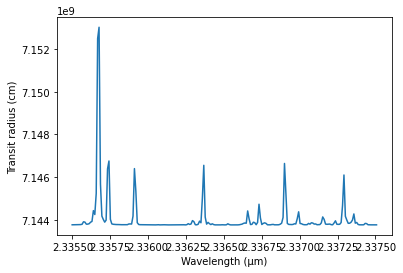

In [7]:
plt.plot(wavelengths[0], transmission_spectrum[0])
plt.xlabel('Wavelength (µm)')
plt.ylabel('Transit radius (cm)')
plt.show()

### Calculating an emssion spectrum
To calculate an emission spectrum, we could create a new `SpectralModel`, but we can use the instance `spectral_model` that we have already:

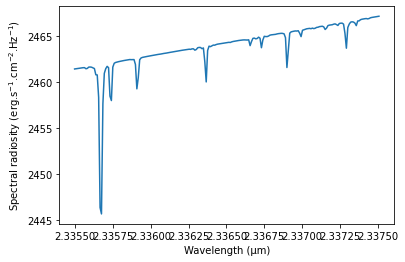

In [8]:
wavelengths, emission_spectrum = spectral_model.get_spectrum_model(
    radtrans=radtrans,  # put the generated radtrans object here
    mode='emission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True  # the parameters that we set will be properly initialised
)

plt.plot(wavelengths[0], emission_spectrum[0])
plt.xlabel('Wavelength (µm)')
plt.ylabel('Spectral radiosity (erg.s$^{-1}$.cm$^{-2}$.Hz$^{-1}$)')
plt.show()

Of course `SpectralModel`s have all the features of `Radtrans` objects: you can generate models with clouds, star spectra etc.

## Setting up a retrieval

Here we will see how to setup a retrieval, and we will also introduce a bit more `SpectralModel` functionalities.
 
### Generating mock observations
First of all, we need data to retrieve. Since we don't have any at hand, we will generate mock observations, so we will use a new `SpectralModel` for this purpose. Of course this step is not necessary if we already have data.

We will model a Jupiter-like planet orbiting a Sun-like star with a radial veocity of 1 km.s-1. There will be 3 exposures around mid transit. The instrument will have a resolving power of 8e4, and a signal-to-noise ratio of 1e6. This time, we will use a combination of imposed mass mixing ratios, and equilibrium chemistry. We will also use a more complex Guillot temperature profile:

In [9]:
# Intialise model and Radtrans object
wavelengths_instrument = np.linspace(2.3355, 2.3375, 150)

data_model = SpectralModel(
    # Radtrans object parameters
    pressures=np.logspace(-10, 2, 100),  # bar
    line_species=[
        'CO_all_iso',
        'H2O_main_iso',
    ],
    rayleigh_species=['H2', 'He'],
    continuum_opacities=['H2-H2', 'H2-He'],
    opacity_mode='lbl',
    lbl_opacity_sampling=4, 
    # Temperature profile parameters
    temperature_profile_mode='guillot',
    temperature=1200,  # K
    intrinsic_temperature=200,  # K
    guillot_temperature_profile_gamma=0.4,
    guillot_temperature_profile_kappa_ir_z0=0.01,
    # Chemical parameters
    use_equilibrium_chemistry=True,  # using chemical equilibrium the first time can take a while, as petitRADTRANS needs to load a large file
    metallicity=3.0,  # in solar metallicity, normal space
    co_ratio=0.55,
    imposed_mass_mixing_ratios={  # equilibrium CO and H2O abundances will be overrided with the values below
        'CO_all_iso': 1e-3,
        'H2O_main_iso': 1e-3
    },
    fill_atmosphere=True,  # ensure that the sum of MMRs is 1
    # Transmission spectrum parameters (radtrans.calc_transm)
    planet_radius=1.00 * nc.r_jup,  # cm
    planet_surface_gravity=1e4,  # cm.s-2
    reference_pressure=1e-2,  # bar
    # Instrument parameters
    new_resolving_power=8e4,
    output_wavelengths=wavelengths_instrument,  # um
    # Scaling parameters
    star_radius=1.0 * nc.r_sun,  # cm
    # Orbital parameters
    star_mass=1.0 * nc.m_sun,  # cm
    semi_major_axis=0.01 * nc.AU,  # cm
    orbital_phases=np.array([-0.01, 0.0, 0.01]),
    system_observer_radial_velocities=1e5  # cm.s-1
)

<div class="alert alert-block alert-info">

We did not intialised `wavelength_boundaries` this time: if enough parameters are given, `SpectralModel` can calculate the optimal wavelength range for a given dataset (i.e. data on wavelengths `output_wavelengths`), taking Doppler shift over multiple orbital phases into account.
</div>

In [10]:
print(f"Optimally chosen wavelength boundaries: {data_model.wavelengths_boundaries} µm")

Optimally chosen wavelength boundaries: [2.3353388081122266, 2.337645739159337] µm


In [11]:
radtrans_data = data_model.get_radtrans()

Generating atmosphere...
  Read line opacities of CO_all_iso...
 Done.
  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [12]:
# Initialise some noise
data_uncertainties = np.ones((1, 3, wavelengths_instrument.size)) * 1e-6
noise_matrix = np.random.default_rng().normal(loc=0.0, scale=data_uncertainties, size=data_uncertainties.shape)

In [13]:
# Get the mock data spectrum
wavelengths, data = data_model.get_spectrum_model(
    radtrans=radtrans_data,
    mode='transmission',
    update_parameters=True,
    noise_matrix=noise_matrix,  # add noise to the data
    scale=True,  # scale the spectrum to the star's spectrum
    convolve=True,  # convolve the spectrum to the instrument resolving power
    shift=True,  # Doppler shift the spectrum wavelengths
    rebin=True  # rebin the spectrum to the instrument wavelengths
)

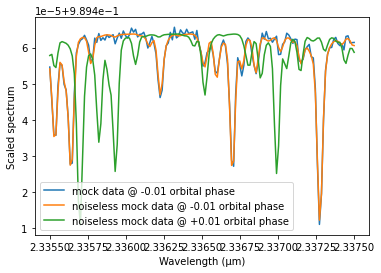

In [14]:
# Plot the spectra
plt.plot(wavelengths[0], data[0, 0], label='mock data @ -0.01 orbital phase')
plt.plot(wavelengths[0], data[0, 0] - noise_matrix[0, 0], label='noiseless mock data @ -0.01 orbital phase')
plt.plot(wavelengths[0], data[0, -1] - noise_matrix[0, -1], label='noiseless mock data @ +0.01 orbital phase')
plt.xlabel('Wavelength (µm)')
plt.ylabel('Scaled spectrum')
plt.legend()
plt.show()

### Setting up the retrieval model and the retrieval itself
Now that our mock data are generated, we need a model to retrieve them. We will use the simpler isothermal temperature model.

In [15]:
retrieval_model = SpectralModel(
    # Radtrans object parameters
    pressures=np.logspace(-10, 2, 100),  # bar
    line_species=[
        'CO_all_iso',
        'H2O_main_iso',
    ],
    rayleigh_species=['H2', 'He'],
    continuum_opacities=['H2-H2', 'H2-He'],
    opacity_mode='lbl',
    lbl_opacity_sampling=4, 
    # Temperature profile parameters
    temperature_profile_mode='isothermal',
    # Chemical parameters
    imposed_mass_mixing_ratios={  # equilibrium CO and H2O abundances will be overrided with the values below
        'CO_all_iso': 1e-12,
        'H2O_main_iso': 1e-12
    },
    fill_atmosphere=True,
    # Transmission spectrum parameters (radtrans.calc_transm)
    planet_radius=1.00 * nc.r_jup,  # cm
    planet_surface_gravity=1e4,  # cm.s-2
    reference_pressure=1e-2,  # bar
    # Instrument parameters
    new_resolving_power=8e4,
    output_wavelengths=wavelengths_instrument,  # um
    # Scaling parameters
    star_radius=1.0 * nc.r_sun,  # cm
    # Orbital parameters
    star_mass=1.0 * nc.m_sun,  # cm
    semi_major_axis=0.01 * nc.AU,  # cm
    orbital_phases=np.array([-0.01, 0.0, 0.01]),
    system_observer_radial_velocities=1e5  # cm.s-1
)

In [16]:
retrieval_model_radtrans = retrieval_model.get_radtrans()

Generating atmosphere...
  Read line opacities of CO_all_iso...
 Done.
  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



We have our model, but we need to specify which parameters to retrieve and their priors. This can be done using a dictionary as follows:

In [17]:
retrieved_parameters = {
    'CO_all_iso': {
        'prior_parameters': [-12, 0],  # uniform prior for MMR from 1e-12 to 1e0
        'prior_type': 'uniform'
    },
    'H2O_main_iso': {
        'prior_parameters': [-12, 0],
        'prior_type': 'uniform'
    },
    'temperature':
    {
        'prior_parameters': [500, 2000],  # uniform prior for temperature from 500 to 2000 K
        'prior_type': 'uniform'
    }
}

<div class="alert alert-block alert-info">

- The retrieved parameter names are the same as the model parameters. You can retrieve any model parameter.
- You can retrieve the decimal logarithm of a model parameter by adding `'log_10_'` in front of its name. E.g., to retrieve the decimal logarithm of `'planet_surface_gravity'`, add to `retrieved_parameters` the key `'log10_planet_surface_gravity'`.
- There are several available types of priors. It is possible to use a custom prior using `'prior_type': 'custom'` and adding key `'custom_prior': my_prior_function`, where `my_prior_function` is a function that has at least an argument `cube`. Other arguments can be passed in a list using the key `'prior_parameters'`.
</div>

<div class="alert alert-block alert-warning">

The retrieval of species abundances is a special case: they are automatically put inside the model parameter `'imposed_mass_mixing_ratios'` and converted from log10 space to into normal space.
</div>

Now, we just need to initialise our `Retrieval` object (ignore the warning, it is deprecated):

In [18]:
retrieval_directory = './'
retrieval_name = 'test'

retrieval = retrieval_model.init_retrieval(
    # Retrieval parameters
    radtrans=retrieval_model_radtrans,
    data=data,
    data_wavelengths=wavelengths_instrument,
    data_uncertainties=data_uncertainties,
    retrieval_directory=retrieval_directory,
    retrieved_parameters=retrieved_parameters,
    retrieval_name=retrieval_name,
    run_mode='retrieval',
    scattering=True,
    # Retrieval model parameters (same as get_spectrum_model arguments)
    mode='transmission',
    update_parameters=True,
    telluric_transmittances=None,
    instrumental_deformations=None,
    noise_matrix=None,
    scale=True,
    shift=True,
    convolve=True,
    rebin=True,
    reduce=False,
)

Starting retrieval test
Setting up PRT Objects


<div class="alert alert-block alert-info">
Model parameters that are not retrieved are de facto fixed parameters. No further action from the user in necessary.
</div>

Now let's run the retrieval!

In [19]:
t0 = time.time()
retrieval_model.run_retrieval(
    retrieval=retrieval,
    n_live_points=10,
    resume=False
)
print(f"Done in {time.time() - t0} s")

Starting retrieval: test

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =   10
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.530973
Replacements:                                 60
Total Samples:                               113
Nested Sampling ln(Z):              -5688.686215
Importance Nested Sampling ln(Z):   -1031.189689 +/-  0.995565
Acceptance Rate:                        0.277078
Replacements:                                110
Total Samples:                               397
Nested Sampling ln(Z):               -356.113555
Importance Nested Sampling ln(Z):    -277.784310 +/-  0.998740
Acceptance Rate:                        0.235641
Replacements:                                160
Total Samples:                        

/tmp/ipykernel_2714/4161763524.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


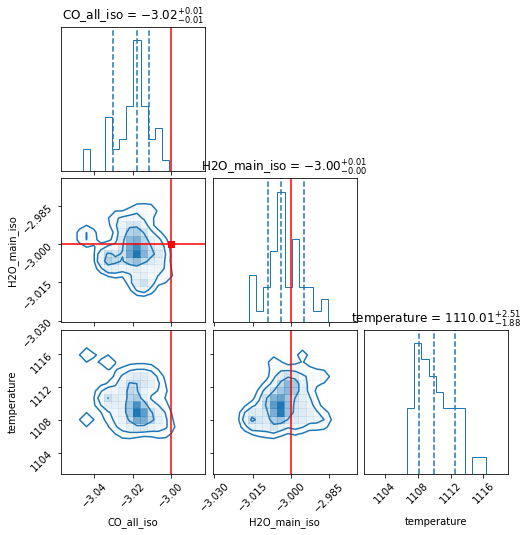

In [20]:
# Plot corner plot
from petitRADTRANS.retrieval.plotting import contour_corner

sample_dict, parameter_dict = retrieval.get_samples(
    output_dir=retrieval_directory + os.path.sep,
    ret_names=[retrieval_name]
)

n_param = len(parameter_dict[retrieval_name])
parameter_plot_indices = {retrieval_name: np.arange(0, n_param)}

fig = contour_corner(
    sample_dict, parameter_dict, os.path.join(retrieval_directory, f'corner_{retrieval_name}.png'),
    parameter_plot_indices=parameter_plot_indices,
    true_values={'test': [
        np.log10(data_model.model_parameters['imposed_mass_mixing_ratios']['CO_all_iso'][0]),
        np.log10(data_model.model_parameters['imposed_mass_mixing_ratios']['H2O_main_iso'][0]),
        data_model.model_parameters['temperature'],
    ]}, 
    prt_plot_style=False
)

fig.show()


## Saving and loading models
You can save `spectral_model` and all its parameters by simply executing:

In [21]:
spectral_model.save('./my_spectral_model.h5')

<div class="alert alert-block alert-info">

`SpectralModel` are saved into HDF5-formatted files. 
    
All parameters are saved, as well as the spectrum itself, but not the `Radtrans` object. If you want to re-calculate the spectrum of a loaded `SpectralModel`, you need to re-generate a `Radtrans` object (hopefully your opacity files have not changed!) before calling the `get_spectrum_model` function.
</div>

<div class="alert alert-block alert-warning">

Custom functions are currently **not** saved.
</div>

You can load the model by doing:

In [22]:
loaded_spectral_model = SpectralModel.load('./my_spectral_model.h5')

## Order of operations
A default `SpectralModel` performs several operations following this order:
1. Calculate the spectral parameters using `SpectralModel.calculate_spectral_parameters`:
    1. Calculate `planet_mass` or `planet_surface_gravity` if missing, using respectively `SpectralModel.surface_gravity2mass` or `SpectralModel.mass2surface_gravity`
    2. Calculate `metallicity`, using `SpectralModel.calculate_scaled_metallicity`
    3. Calculate the temperature profile using `SpectralModel.calculate_temperature_profile`
    4. Calculate the mass mixing ratios as a function of pressure using `SpectralModel.calculate_mass_mixing_ratios`
    5. Calculate the mean molar mass as a function of pressure using `SpectralModel.calculate_mean_molar_masses`
    6. If `SpectralModel.mode` is `'emission'` and the model parameter `is_orbiting` is `True`:
        1. If `star_spectral_radiosities` is missing, calculate it using `SpectralModel.calculate_star_spectral_radiosities`
        2. Calculate `planet_star_spectral_radiances`, using `SpectralModel.calculate_planet_star_spectral_radiances`
    7. If the model parameter `is_orbiting` is `True`:
        1. If `planet_radial_velocity_amplitude` is missing, calculate it using `SpectralModel.calculate_radial_velocity_amplitude`
        2. Calculate `planet_radial_velocities` using `SpectralModel.calculate_planet_radial_velocities`
    8. Calculate `relative_velocities` using `SpectralModel.calculate_relative_velocities`
2. Calculate the raw spectrum: 
    - If `SpectralModel.mode` is `'emission'`, use `Radtrans.calc_flux`
    - If `SpectralModel.mode` is `'transmission'`, use `Radtrans.calc_transm`
3. Do several operations on the raw spectrum using `SpectralModel.modify_spectrum`:
    1. If `SpectralModel.mode` is `'emission'`:
        1. If the planet is orbiting a star and `shift` is `True`, Doppler-shift `star_spectral_radiosities` to correct for the planet radial orbital velocity
        2. If the model parameter `is_observed` is `True`:
            1. If the planet is orbiting a star, add the previously Doppler-shift `star_spectral_radiosities` to the spectrum and calculate the star spectrum reaching the observer
            2. Calculate the planet (+ star) spectrum reaching the observer
    2. If `scale` is `True`, scale the spectrum to the star spectrum, using `SpectralModel.scale_spectrum`
    3. If `shift` is `True`, get the spectrum wavelengths in the rest frame of the observer, using `SpectralModel.shift_wavelengths`
    4. If any `telluric_transmittances` is given:
        1. If `shift` is `True`, correct the telluric transmittances from the planet Doppler-shift
        2. If any `airmass` is given, add its effect to the telluric transmittances
        3. Multiply the spectrum by the telluric transmittances
    5. If `convlove` is `True`, convolve the spectrum at the `new_resolving_power` resolution, using `SpectralModel.convolve`
    6. If `rebin` is `True`, rebin the spectrum on the `output_wavelengths`, using `SpectralModel.rebin_spectrum`
    7. If any `instrumental_deformations` is given, multpily the spectrum by it
    8. If any `noise_matrix` is given, add it to the spectrum
4. If `reduce` is `True`, prepare the spectrum using `SpectralModel.pipeline`

Some of the default functions used are described below.

<div class="alert alert-block alert-info">

All of the `SpectralModel` default functions can be customised (see [using custom functions](#Using-custom-functions)).
</div>

### Temperature profile function
`SpectralModel.calculate_temperature_profile` has 2 default modes to calculate the temperature profile of a model. The modes are accessed with the model parameter `temperature_profile_mode`. They are:
- `'isothermal'`, to use an isothermal profile; this mode requires only the model parameter `temperature`.
- `'guillot'`, to use a Guillot metallicity-dependent temperature profile; this mode requires the model parameters:
    - `guillot_temperature_profile_gamma`,
    - `planet_surface_gravity`,
    - `intrinsic_temperature`,
    - `temperature` (the equilibrium temperature in Guillot's equation),
    - `guillot_temperature_profile_kappa_ir_z0`,
    - `metallicity` (optional, default is 1 i.e. the solar metallicity)

### Mass mixing ratio function
`SpectralModel.calculate_mass_mixing_ratios` can calculate MMRs from a mix of equilibrium chemistry and imposed MMRs. The function operates as follows:
1. If `use_equilibrium_chemistry` is `True`, the function uses `petitRADTRANS.poor_mans_nonequ_chem` to get the MMRs from the following model parameters:
    - `co_ratios`: the C/O ratio
    - `metallicity` (can be calculated in step 1.B.)
    - `carbon_pressure_quench`: the pressure at which the carbon species abundances stay constant going to lower pressures
2. If the sum of the `imposed_mass_mixing_ratios` is > 1 at a pressure level, every `imposed_mass_mixing_ratios` is divded by the sum at this pressure level
3. If applicable, the MMRs from equilibrium chemistry are overrided by the `imposed_mass_mixing_ratios`
4. If the sum of the MMRs is > 1 at a pressure level, every MMRs is divded by the sum at this pressure level
5. If the sum of the MMRs is < 1 at a pressure level and model parameter `fill_atmosphere` is `True`, then add H2 and He so that [H2] + [He] + sum(MMRs) = 1 at this pressure level, with [He]/[H2] = constant
    - If H2 and He were given in `imposed_mass_mixing_ratios`, keep the H2/He ratio from there
    - If not, use the model parameter `heh2_ratio`

### Mean molar mass function
In `SpectralModel.calculate_mean_molar_masses`, the MMWs are calculated using the MMRs and the molar masses from the [molmass](https://pypi.org/project/molmass/) module.

### Relative velocities functions
In `SpectralModel.calculate_relative_velocities`, the relative velocities are calculated by default from the following model parameters:
- `system_observer_radial_velocities`: corresponding the combination of V_bary (the barycentric radial velocity, i.e. the radial velocity between the observer and the solar system barycenter) and V_sys (the systemic radial velocity, i.e. the radial velocity between the solar system barycenter and the planet's star, or the planet itself if it is free-floating).
- `planet_radial_velocities`: the radial velocity of the planet with respect to the observer in its star reference frame. It can be calculated from model parameters:
    - `planet_radial_velocity_amplitude`: also known as K_p
    - `orbital_longitudes` or `orbital_phases`
- `planet_rest_frame_velocity_shift`: an arbitrarty scalar shift.
If the planet is not orbiting (model parameter `is_orbiting` is `False`), then `planet_radial_velocities` is not taken into account.

### Convolving function
In `SpectralModel.convolve`, several operations are performed:
1. The resolving power of the input wavelengths (here, the wavelengths of the spectrum) is calculated using `SpectralModel.calculate_bins_resolving_power`.
2. Then:
    - If this input resolving power vary less than model parameter `constance_tolerance`, a constant convolution function is used
    - Else, a running convolution (much slower) is performed

### Preparing pipeline
The preparing pipleline used by default in `SpectralModel.pipeline` is `petitRADTRANS.retrieval.preparing.preparing_pipeline`. The pipeline is performed on the last 2 dimensions of the spectrum (exposures, wavelengths), and is using a n-order polynomial fit. The most relevant model parameters are:
- `uncertainties`: the uncertainties on the spectrum
- `tellurics_mask_threshold`: the value of the telluric lines fit below which to mask the prepared spectrum
- `polynomial_fit_degree`: the order of the fit
- `airmass`: the airmass of observations, for the telluric lines fit (if not provided, a mean fit will be used instead)

<div class="alert alert-block alert-warning">

Another important parameter is `wavelengths`. In the `SpectralModel` framework, `wavelengths` is automatically set as the spectrum wavelengths. However, when using `SpectralModel.pipeline` independently from the framework, this parameter is not automatically filled. If not filled, the mean function will be used to fit over the wavelengths, instead of an n-order polynome.
</div>

## More insight
`SpectralModel`s have 3 kinds of attributes: 
1. `Radtrans` parameters, which are in common with the `Radtrans` object.
2. Spectral parameters, which are: 
    - the temperature profile used to generate the spectrum,
    - the mass mixing ratios used to generate the spectrum,
    - the mean molar masses used to generate the spectrum,
    - the wavelengths of the spectrum,
    - the transit radii of the transmission spectrum,
    - the spectral radiosities (also called "flux") of the emission spectrum,
3. Model parameters stored into the attribute `model_parameters`.

In the code example to generate `spectral_model`, the comments indicates which arguments were used to initialise `Radtrans` or model parameters.

<div class="alert alert-block alert-info">

When initialising a `SpectralModel` object, all parameters that are not spectral parameters and not attributes of `Radtrans` objects, i.e. model parameters, are stored into the attribute `model_parameter`, in the form of a dictionary. 
    
You can add as many model parameters as you want when initialising a `SpectralModel`, or afterward. You can even add model parameters that does nothing. However, be careful about the spelling of actually useful parameters!
</div>

Basically, `Radtrans` and model parameters are your inputs, and spectral parameters are your outputs: once a model is calculated, you can use the spectral parameters to visualise the results.

In practice, you would only initialise `Radtrans` and model parameters. You can initialise spectral parameters e.g. if you have a temperature profile generated by a self-consistent model. In that case, to correctly calculate the spectrum, be careful to set `update_parameters=False` when calling the `get_spectrum_model`. Otherwise, your temperature profile could be updated with a `SpectralModel` temperature profile. To check that, you can use the fact that, after the call of `get_spectrum_model`, the values stored into the spectral parameters are **always** the values used to generate the spectrum.

### Changing the value of a `model_parameter`
Let's say that you now want your model to have a temperature of 1200 K instead of 800 K. In that case, simply update the `temperature` model parameter and re-generate the spectrum model:

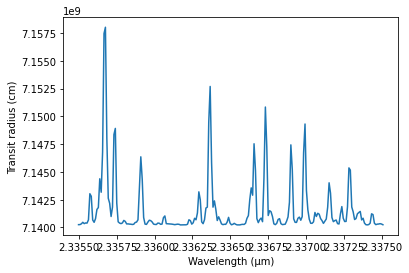

In [23]:
spectral_model.model_parameters['temperature'] = 1200  # K

wavelengths, transmission_spectrum = spectral_model.get_spectrum_model(
    radtrans=radtrans,
    mode='transmission',
    update_parameters=True  # don't forget to update the parameters
)

plt.plot(wavelengths[0], transmission_spectrum[0])
# Add fancy labelling
plt.xlabel('Wavelength (µm)')
plt.ylabel('Transit radius (cm)')
plt.show()

### Changing a `Radtrans` parameter

Let's say that you now want your model to have add CO to your species. In that case, you first need to add the missing absorber and tell how much MMR of it you want:

In [24]:
spectral_model.line_species.append('CO_all_iso')  # add absorber
spectral_model.model_parameters['imposed_mass_mixing_ratios']['CO_all_iso'] = 1e-3  # absorber MMR

Now, the `spectral_model` has all the required information. But remember: you need a `Radtrans` object to calculate the model. Right now, your instance `radtrans` hasn't loaded all the necessary opacities, so you need to re-generate it:

In [25]:
radtrans = spectral_model.get_radtrans()

Generating atmosphere...
  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_all_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



 **Now** you can re-calculate the spectrum, using the updated `radtrans`:

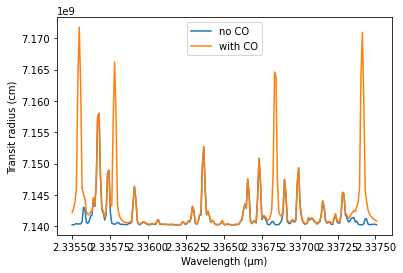

In [26]:
wavelengths, transmission_spectrum_with_co = spectral_model.get_spectrum_model(
    radtrans=radtrans,
    mode='transmission',
    update_parameters=True  # don't forget to update the parameters
)

plt.plot(wavelengths[0], transmission_spectrum[0], label='no CO')  # plot the previous spectrum to see the difference
plt.plot(wavelengths[0], transmission_spectrum_with_co[0], label='with CO')  # plot the new spectrum
# Add fancy labelling
plt.xlabel('Wavelength (µm)')
plt.ylabel('Transit radius (cm)')
plt.legend()
plt.show()

What if you want to change the abundance of CO? Since this is **not** a `Radtrans` parameter (it is a `model_parameter`), you can update the value just like the temperature:

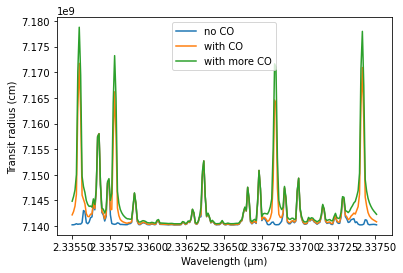

In [27]:
# Update model parameter
spectral_model.model_parameters['imposed_mass_mixing_ratios']['CO_all_iso'] = 5e-3

# Re-generate model
wavelengths, transmission_spectrum_with_more_co = spectral_model.get_spectrum_model(
    radtrans=radtrans,
    mode='transmission',
    update_parameters=True  # don't forget to update the parameters
)

# Plot the new spectrum and the prvious ones
plt.plot(wavelengths[0], transmission_spectrum[0], label='no CO')
plt.plot(wavelengths[0], transmission_spectrum_with_co[0], label='with CO')
plt.plot(wavelengths[0], transmission_spectrum_with_more_co[0], label='with more CO')
# Add fancy labelling
plt.xlabel('Wavelength (µm)')
plt.ylabel('Transit radius (cm)')
plt.legend()
plt.show()

### Using custom functions

Any function of `SpectralModel` can be edited, e.g.:


In [28]:
# Save old model
spectral_model_old = copy.deepcopy(spectral_model)  # not necessary, only used for the plots

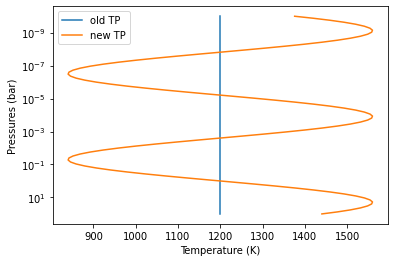

In [29]:
# Set a new temperature profile function based on some top notch physics
def my_t_profile(pressures, my_parameter, x, **kwargs):  # the **kwargs is important, even if it's not used
    # Note that the "temperature" model parameter is not necessary, but it cloud replace "x"
    return x * (1 + 0.3 * np.sin(np.deg2rad(my_parameter * np.log(pressures))))

# Change the temperature profile of the model, add necessary model parameters for the new TP model
spectral_model.model_parameters['my_parameter'] =  30 # added here, but can also be added during instanciation just like any other model parameter
spectral_model.model_parameters['x'] =  1200 # an overly complex and specific parameter
spectral_model.calculate_temperature_profile = my_t_profile

# Re-generate model
wavelengths, transmission_spectrum_new_tp = spectral_model.get_spectrum_model(
    radtrans=radtrans,
    mode='transmission',
    update_parameters=True  # don't forget to update the parameters
)

plt.semilogy(spectral_model_old.temperatures, spectral_model_old.pressures, label='old TP')  # plot the previous spectrum to see the difference
plt.semilogy(spectral_model.temperatures, spectral_model.pressures, label='new TP')  # plot the new spectrum
# Add fancy labelling
plt.gca().invert_yaxis()
plt.xlabel('Temperature (K)')
plt.ylabel('Pressures (bar)')
plt.legend()
plt.show()

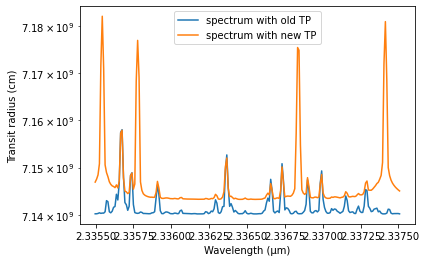

In [30]:
plt.semilogy(wavelengths[0], transmission_spectrum[0], label='spectrum with old TP')  # plot the previous spectrum to see the difference
plt.semilogy(wavelengths[0], transmission_spectrum_new_tp[0], label='spectrum with new TP')  # plot the new spectrum
# Add fancy labelling
plt.xlabel('Wavelength (µm)')
plt.ylabel('Transit radius (cm)')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">

A `SpectralModel` with a custom function can be used for a retrieval as well. Custom `model_parameters` can be retrieved just like the default ones.
</div>